In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from os import listdir
import fitz

## Understanding how to extract each panel

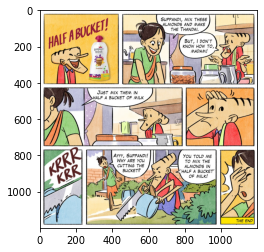

In [2]:
img = cv2.imread("Sample_img.jpg")              #Importing image 
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)     #Converting image to grayscale
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) #Displaying the grayscale image

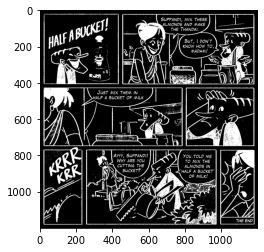

In [3]:
thresh_inv = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1] #Applying threshold to gray image
plt.imshow(cv2.cvtColor(thresh_inv,cv2.COLOR_BGR2RGB)) #Displaying thresholded image

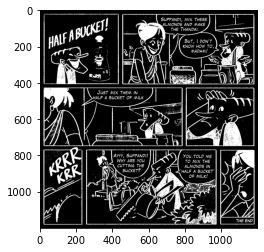

In [4]:
#Applying Gaussian Blur to the thresholded image [Note that the kernal size (1,1) works best here]
blur = cv2.GaussianBlur(thresh_inv,(1,1),0) 
#This blur image is thresholded again for better accuracy
thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
#Displaying thresh
plt.imshow(cv2.cvtColor(thresh,cv2.COLOR_BGR2RGB))

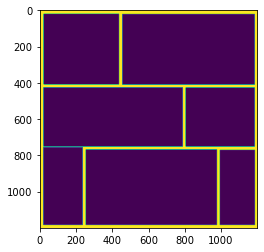

In [5]:
#Finding contours in the image
contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
#Creating an blank image in the size of the original image
mask = np.ones(img.shape[:2], dtype="uint8")*255

for c in contours:
    x,y,w,h = cv2.boundingRect(c) #Calculates the up-right bounding rectangle given the contours. 
    
    if(w*h>(img.shape[0]*img.shape[1]/30)):  #If the box is big enough we draw a rectangle in the mask
        mask = cv2.rectangle(mask,(x,y),(x+w,y+h),(0,0,255),-1)

plt.imshow(mask)

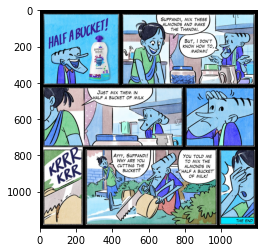

In [6]:
res_final = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
plt.imshow(res_final) #Display the final result

### Making a function that could return us an array of panels 

In [7]:
def ret_boxes(img):
        img_array = []
        
        img = cv2.rectangle(img,(0,0),img.shape[:2][::-1],(255,255,255),10)
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

        # Blur the image
        blur = cv2.GaussianBlur(thresh_inv,(1,1),0)

        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

        # find contours
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

        mask = np.ones(img.shape[:2], dtype="uint8") * 255
        for c in contours:
            # get the bounding rect
            x, y, w, h = cv2.boundingRect(c)
            if w*h>(img.shape[0]*img.shape[1]/16) :
                cv2.rectangle(mask, (x, y), (x+w, y+h), (0, 0, 255), -1)
                img_array.append(img[y:y+h,x:x+w])

        res_final = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
        return(img_array[::-1])

### Now lets test it out with a few images

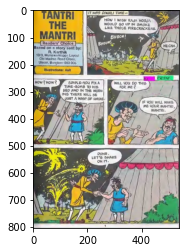

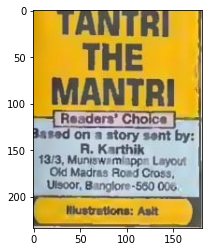

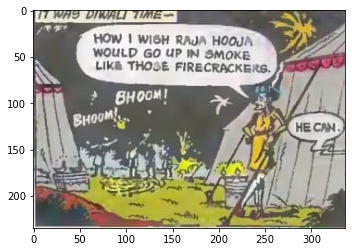

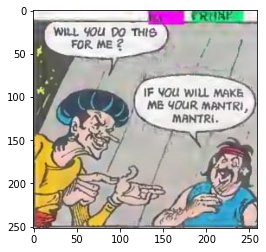

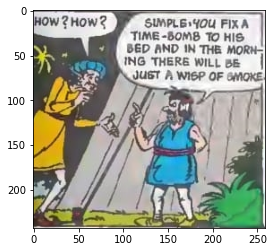

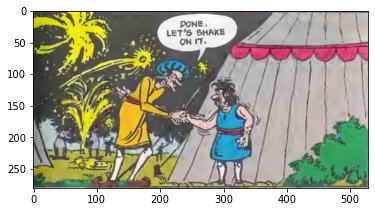

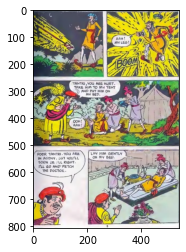

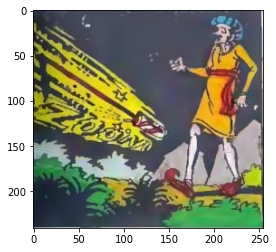

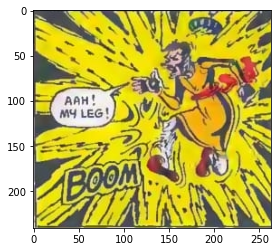

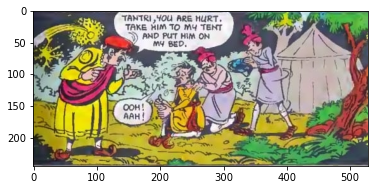

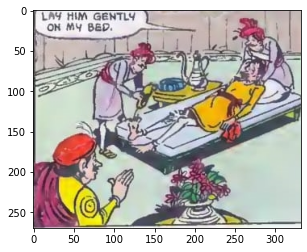

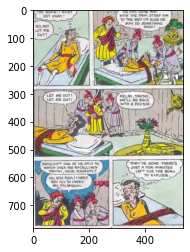

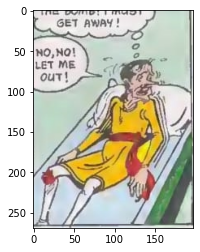

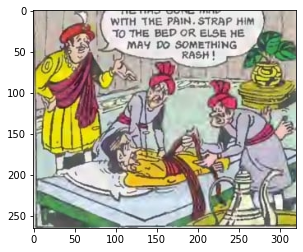

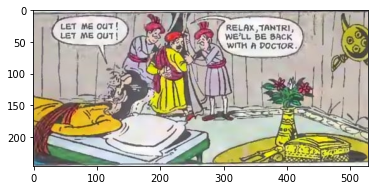

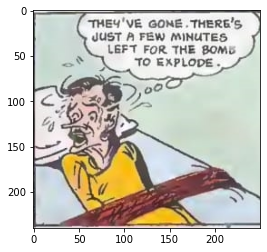

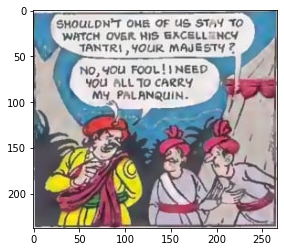

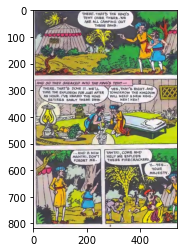

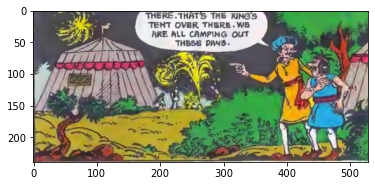

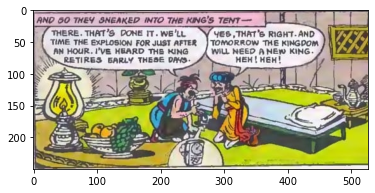

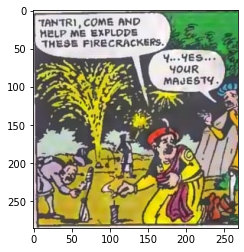

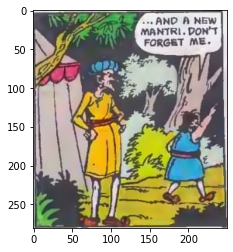

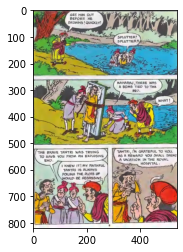

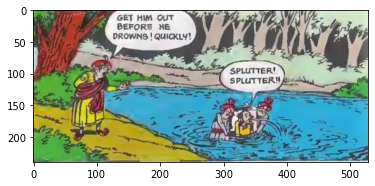

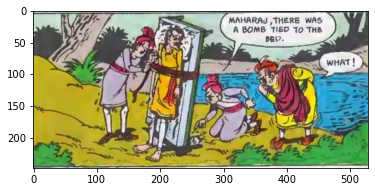

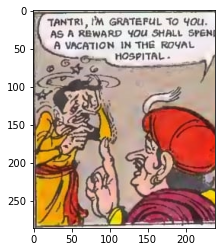

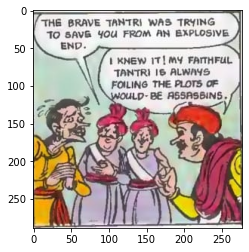

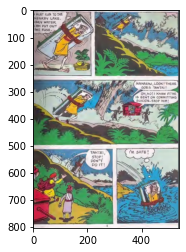

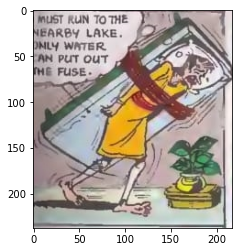

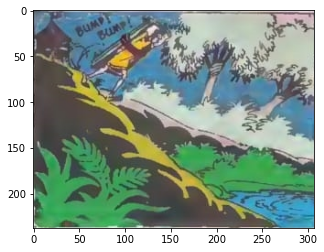

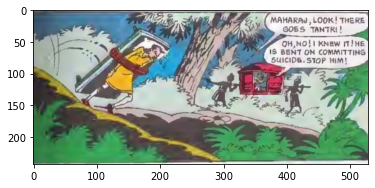

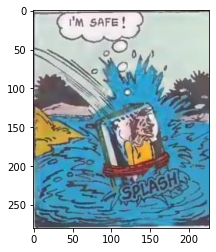

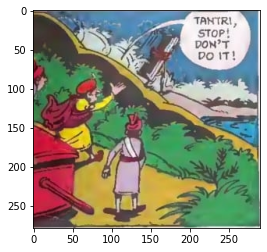

In [8]:
img_dir = "Story_One"
for im in listdir(img_dir):
    img = cv2.imread(img_dir+"/"+im)
    try:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
        plt.show()
        for im in ret_boxes(img):
            plt.imshow(cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
            plt.show()
    except:
        pass

### Using cv2.imshow()
If we try using cv2.imshow(img) we ould notice a peculiar issue,

<B> Too BIG </B>
<!-- ![image.png](attachment:image.png) -->
<!-- ![image-6.png](attachment:image-6.png) -->
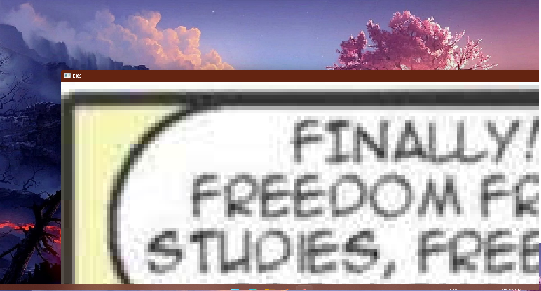
    
<B> Too Small </B>
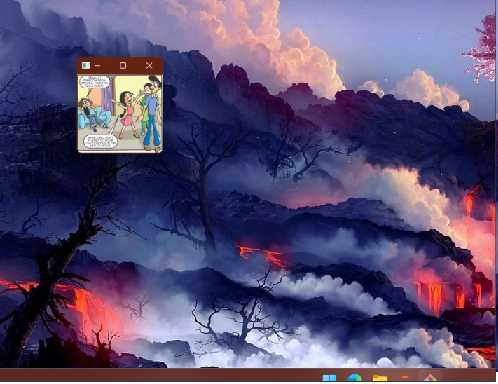
<!-- ![image-2.png](attachment:image-2.png) -->

    
    
Few images are too big and few are too small

<B> Inoder to solve this issue we create a function that could maintain the aspect ratio of image while maintaining the picture at the same size.

In [9]:
def maintain_aspect_ratio_resize(image, width=400, height=400, inter=cv2.INTER_AREA):
    (h, w) = image.shape[:2]
    rh = int(w * (height / float(h)))
    dim = (rh, height)        
    return cv2.resize(image, dim, interpolation=inter)

In [10]:
img_dir = "Story_One"

for im in listdir(img_dir):
    img = cv2.imread(img_dir+"/"+im)
    if img is not None:
        for im in ret_boxes(img):
            im = maintain_aspect_ratio_resize(im)
            cv2.imshow("pics",im)
            if(cv2.waitKey(10000) &  0xff != 27):
                continue
    cv2.destroyAllWindows()

### Lets convert pdf 
Now that we can convert a series of images panel by panel, let us now try it with a pdf

In [11]:
pdf_dir = "Story_One/Ina_mina_mynah_mo.pdf"
doc = fitz.open(pdf_dir)
# doc.page_count
for i in range(4):
    page = doc.load_page(i)  # number of page
    pix = page.get_pixmap(dpi=500)
    temp_png = "Story_One/temp/temp.jpeg" 
    pix.save(temp_png) #saving it as a temproary image
    img = cv2.imread(temp_png) 

    for im in ret_boxes(img):
        im = maintain_aspect_ratio_resize(im)
        cv2.imshow("pics",im)
        if(cv2.waitKey(10000) &  0xff == 27):
            continue
cv2.destroyAllWindows()


And thus we can split a given comic panel by panel.
This may not perform with hundred percent efficiency as it is purely dependent on the contour detection, and come comics have arts that extend beyond the panel(box),

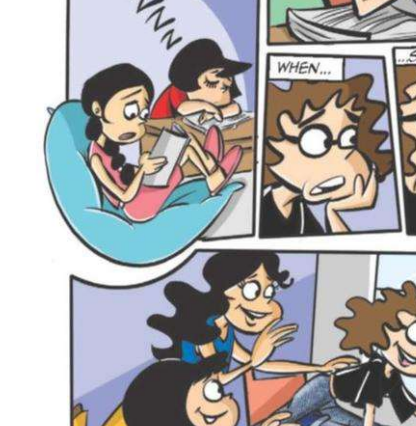
and this..
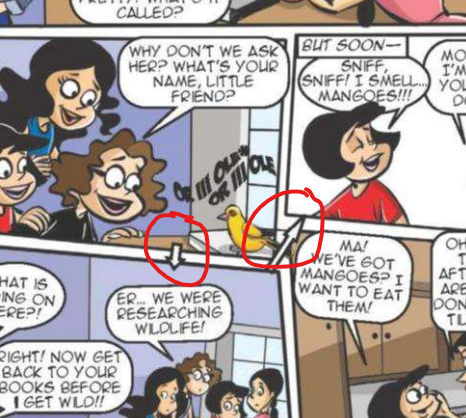

It becomes hard to identify the automatically with just contour detection and thus here i have considered a few panels together for such cases.

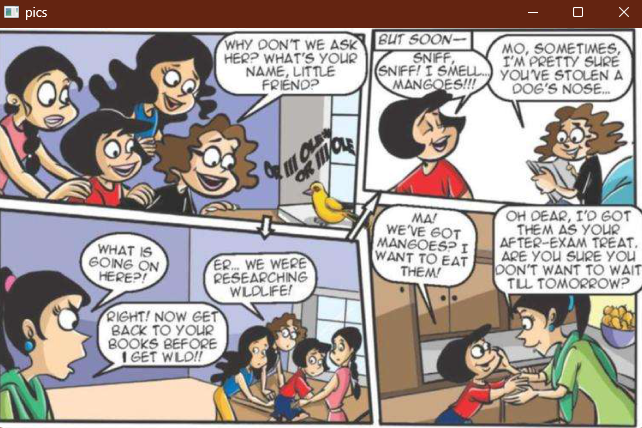


<B>Hope You Enjoyed my code!